# Testing Multifidelity MES against a Synthetic Function (June 2024)

These plots will be needed for the write-up.

## i) Non-batch Case

In [1]:

import pandas as pd
import numpy as np
import torch

from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP, SingleTaskGP
from botorch.posteriors.gpytorch import scalarize_posterior
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from botorch.acquisition import PosteriorMean 
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
import numpy as np
from scipy.spatial.distance import cdist
from botorch import fit_gpytorch_mll
torch.set_printoptions(precision=12, sci_mode=False)
import copy
import math
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

def covSEard(hyp, x, z):
    """
    ARD covariance:
        x is of dimension n X D
        y is of dimension m X D
    """
    hyp = np.exp(hyp)

    D = x.shape[1]
    X = (1 / hyp[:D]) * x

    Z = (1 / hyp[:D]) * z
    K = cdist(X, Z)

    K = hyp[D] ** 2 * np.exp(-K ** 2 / 2)

    return K

def rkhs_synth(x):
    """
    RKHS Function
        Description: Synthetic heteroscedastic function generated from 2 Squared Exponential kernels
                     for Bayesian Optimization method evaluation tasks
        Evaluated: x \in [0,1]
        Global Maximum: x=0.89235, f(x)=5.73839
        Authors: Ziyu Wang, John Assael and Nando de Freitas
    """

    x = np.atleast_2d(x)
    hyp_1 = np.log(np.array([0.1, 1]))
    hyp_2 = np.log(np.array([0.01, 1]))

    support_1 = [0.1, 0.15, 0.08, 0.3, 0.4]
    support_2 = [0.8, 0.85, 0.9, 0.95, 0.92, 0.74, 0.91, 0.89, 0.79, 0.88, 0.86, 0.96, 0.99, 0.82]
    vals_1 = [4, -1, 2., -2., 1.]
    vals_2 = [3, 4, 2, 1, -1, 2, 2, 3, 3, 2., -1., -2., 4., -3.]

    f = sum([vals_2[i] * covSEard(hyp_2, np.atleast_2d(np.array(s)), x) for i, s in enumerate(support_2)])
    f += sum([vals_1[i] * covSEard(hyp_1, np.atleast_2d(np.array(s)), x) for i, s in enumerate(support_1)])

    return float(f)

In [2]:
import random
import time
import pickle
import os

def setUpSampleSpace(spaceSize=200):
    Xpr = np.linspace(0,1,spaceSize)
    
    domain = []
    for x in Xpr:
       domain.append( [x, 1.0, rkhs_synth(x)])
       domain.append( [x, 0.5, rkhs_synth(x) + random.gauss(0, 1)])
    
    domain = np.array(domain)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fileName = 'SampleSpaces/'+timestr + '.csv'
    np.savetxt(fileName, domain, delimiter=',')

    return fileName

def setUpInitialData(sampleSpaceName, initialSize=10, predefined_indices = None, sf=False, file=True):
      # The file argument is telling us whether we expect the sampleSpaceName to be a file or the actual domain is already in memory.
      # The predefined_indices argument us used in the batch case acorss multiple search-algorithms where we want 
      #  each element in the batch to have the same intitial set up so that we can compare the averages fairly.
      sampleSpace = np.loadtxt(sampleSpaceName, delimiter=',') if file else sampleSpaceName
      if predefined_indices is None:  
            sampleSpace_hf = sampleSpace[np.where(sampleSpace[:, 1]==1)]
            size = len(sampleSpace_hf)
            index_store = random.sample(range(size), initialSize)
            #This gets the high fidelity and low fidelity points in pairs if we're doing MF.
            sampleSpace, index_store = (sampleSpace_hf, index_store) if sf else (sampleSpace, [2 * x  for x in  index_store] + [1 + 2 * x for x in index_store])
            fidelity_history = sampleSpace[index_store, 1]
            train_X = sampleSpace[index_store, :-1]
            train_obj = sampleSpace[index_store, -1:]
            return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, index_store, fidelity_history.flatten().tolist()
      else:
            fidelity_history = sampleSpace[predefined_indices, 1]
            train_X = sampleSpace[predefined_indices, :-1]
            train_obj = sampleSpace[predefined_indices, -1:]
            return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, predefined_indices, fidelity_history.flatten().tolist()

# Required when we want to ensure that the sf has the same hf points in its intitial sampel as the mf case.
def convertMFDatatoSFData(sampleSpace, indexStore):
      sampleSpace_hf = sampleSpace[np.where(sampleSpace[:, 1]==1)]
      index_store = [x // 2 for x in indexStore if x % 2 == 0]
      return torch.tensor(sampleSpace_hf[index_store, : -1]), torch.tensor(sampleSpace_hf[index_store, -1:]), sampleSpace_hf, index_store, sampleSpace[index_store, 1].flatten().tolist()
    

def save_dictionary(dictionary, batch=False, root='SearchDictionaries'):
      os.makedirs(root, exist_ok=True)
      timestr = time.strftime("%Y%m%d-%H%M%S")
      fileName = root + '/' + 'Batch_' + timestr if batch else root + '/' + timestr
      with open(fileName, 'wb') as handle:
         pickle.dump(dictionary, handle)
      return fileName

def load_dictionary(file):
    with open(file, 'rb') as inp:
      output = pickle.load(inp)
      return output

In [11]:
file = setUpSampleSpace(1000)
# file = save_dictionary(searchDictBatch, True)
# print(load_dictionary(file))
# train_X, train_obj, domain, index_store, budget = setUpInitialData(file, 10)

In [3]:
def runMes(model, Xrpr, previous_evaluations=None, train_x_past=None):
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]])
    candidate_set = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(10000, 1)
    target_fidelities = {1: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={1: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    acquisition = qMultiFidelityMaxValueEntropy(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            candidate_set=candidate_set,
        )
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]))
    return acquisitionScores

In [4]:
def runKG(model, Xrpr, previous_evaluations=None, train_x_past=None):
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]])
    target_fidelities = {1: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={1: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    curr_val_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=Xrpr.shape[1],
        columns=[Xrpr.shape[1]-1],
        values=[1],
    )                
    _, current_value = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds[:,:-1],
        q=1,
        num_restarts= 2,
        raw_samples=4
    )
    acquisition = qMultiFidelityKnowledgeGradient(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            current_value=current_value,
            num_fantasies= 5
        )
    acquisitionScores =  acquisition.evaluate(Xrpr.reshape(-1,1, Xrpr.shape[1]), bounds=bounds).detach()
    return acquisitionScores

In [5]:
def runEI(model, Xrpr, previous_evaluations, train_x_past=None):
    Xrpr = torch.tensor(Xrpr)
    acquisition = ExpectedImprovement(
            model=model,
            best_f= max(previous_evaluations)
        )
    
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]) ).detach()
    return acquisitionScores

In [6]:
def runTVR(model, Xrpr, previous_evaluations=None, train_x_past=None):
    Xrpr_hf = Xrpr[np.where(Xrpr[:, 1]==1)]
    indices = np.where(train_x_past[:, 1] == 1)
    train_obj_hf = previous_evaluations[indices]

    acquisition_scores = runEI(model, Xrpr_hf, train_obj_hf)
    max_hf_ind = acquisition_scores.argmax()

    index_in_xrpr = Xrpr.tolist().index(Xrpr_hf[max_hf_ind].tolist())
    Xrpr = torch.tensor(Xrpr)

    posterior = model.posterior(Xrpr)

    pcov = posterior.distribution.covariance_matrix
    p_var = posterior.variance
    hf_max_cov = pcov[index_in_xrpr]
    hf_max_var = hf_max_cov[index_in_xrpr]
    cost = Xrpr[:, 1]
    
    return hf_max_cov ** 2 / (p_var.reshape(-1) * hf_max_var * cost)

def runTVR_mod(model, Xrpr, previous_evaluations=None, train_x_past=None):
    Xrpr_hf = Xrpr[np.where(Xrpr[:, 1]==1)]
    indices = np.where(train_x_past[:, 1] == 1)
    train_x_hf  = train_x_past[indices][:, :-1].unsqueeze(-1)
    train_obj_hf = previous_evaluations[indices]

    #We create a new model that is just single-fidelity. (Maybe we just use existing MF model with only HF inputs. Worth thinking about.)
    model_hf = SingleTaskGP(train_x_hf[:, 0], train_obj_hf)
    acquisition_scores = runEI(model_hf, Xrpr_hf[:, 0].reshape(-1,1), train_obj_hf)
    max_hf_ind = acquisition_scores.argmax()

    # acquisition_scores = runEI(model, Xrpr_hf[:, :], train_obj_hf)
    # max_hf_ind = acquisition_scores.argmax()


    index_in_xrpr = Xrpr.tolist().index(Xrpr_hf[max_hf_ind].tolist())
    Xrpr = torch.tensor(Xrpr)

    posterior = model.posterior(Xrpr)

    pcov = posterior.distribution.covariance_matrix
    p_var = posterior.variance
    hf_max_cov = pcov[index_in_xrpr]
    hf_max_var = hf_max_cov[index_in_xrpr]
    cost = Xrpr[:, 1]
    
    return hf_max_cov ** 2 / (p_var.reshape(-1) * hf_max_var * cost)
    
    

In [12]:
X = torch.tensor(np.array([[1.1], [1.2], [1.3]]))
y = torch.tensor(np.array([[1.4], [1.6], [1.9]]))
model = SingleTaskGP(X, y)
output = model.posterior(torch.tensor([[1], [2]]))
varaince = 1

In [7]:
def optimiseAcquisitionFunction(sortedAcqusitionScores, domain, trainingData, index_store):
    # X_detached = trainingData.detach().numpy()
    # def checkFunction(candidate, set):
    #     for x in set:
    #         if np.array_equal(candidate[:-1], x):
    #             return True
    #     return False
    def checkIndexNotAlreadyEvaluated(candidate, set):
        return candidate in set
    
    for i in range(domain.shape[0]):
        if not checkIndexNotAlreadyEvaluated(sortedAcqusitionScores[i].item(), index_store):
            index_store.append(sortedAcqusitionScores[i].item())
            return domain[sortedAcqusitionScores[i], 0], domain[sortedAcqusitionScores[i], 1], domain[sortedAcqusitionScores[i], 2]
            # , sortedAcqusitionScores[i]

In [8]:
def run_entire_cycle(train_x_full, 
                     train_obj, 
                     domain, 
                     fidelity_history, 
                     index_store, 
                     func,
                     sf=False, 
                     no_of_iterations=100000, 
                     allocated_budget=100000
                     ):
    train_x_full = copy.deepcopy(train_x_full)
    train_obj = copy.deepcopy(train_obj)
    fidelity_history = copy.deepcopy(fidelity_history)
    index_store = copy.deepcopy(index_store)
    
    domain_X_only = domain[:, 0:-1]
    budget_sum = sum(fidelity_history)
    iteration_counter = 0
    while budget_sum  <= allocated_budget - 1 and iteration_counter < no_of_iterations: 
        # The - 1 important in the budget (as well as the equal) as the check happens at the start and we only really care about high-fidelity points.
        # Consider a budget of 40, and when we hit the sum at 39. We would want the subsequent step to be the last
        # as at most we can add 1. If we instead only add 0.5, you could argue that stopping at 39.5 is premature
        # and we could go another step since it's possible to get another low-fidelity point, but this does not interest us.
        # It's the high-fidelity points we care about and then that would exceed the budget.
        model = SingleTaskGP(train_x_full, train_obj) if sf else SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelity=1)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)  
        acquisitionScores = func(model=model, Xrpr=domain_X_only, previous_evaluations=train_obj, train_x_past=train_x_full )
        sorted_acqusition_scores = acquisitionScores.argsort(descending=True)
        top_candidate, fidelity, evaluation = optimiseAcquisitionFunction(sorted_acqusition_scores, domain, train_x_full, index_store)
        fidelity_history.append(fidelity)
        train_x_full = torch.cat([train_x_full, torch.tensor([top_candidate, fidelity]).unsqueeze(0)])
        train_obj = torch.cat([train_obj, torch.tensor([evaluation]).unsqueeze(-1)])
        iteration_counter+=1
        budget_sum += fidelity
    cumulative_cost = [fidelity_history[0]]
    for i in range(len(fidelity_history) - 1):
        cumulative_cost.append(cumulative_cost[-1] + fidelity_history[i+1])
    return train_x_full, train_obj, cumulative_cost, index_store

def run_entire_cycle_random(no_of_iterations, domain, x_train=None):
    if x_train is None:                   
        #Here we will only consider high-fidelity points since we are just randomly choosing points and ignore the intitial sample.
        #Since high-fidelity points have a fidelity of 1 this means the allocated_budget is the same as the number of iterations.
        high_fidelity_points = domain[np.where(domain[:, 1] == 1.0)]
        
        number_of_hf_points = len(high_fidelity_points)
        index_store = random.sample(range(number_of_hf_points), no_of_iterations)
        train_X_full = high_fidelity_points[index_store][:, :-1]
        train_obj = high_fidelity_points[index_store][:, -1]
        cumulative_cost = list(range(1, no_of_iterations + 1))
        return torch.tensor(train_X_full), torch.tensor(train_obj).unsqueeze(-1), cumulative_cost, [2 * x  for x in index_store]
    else:
        # This is for when we want to do a random search, but keep the initial points already computed in the initial sampling used by other techniques.
        # The benefit of this is when we wish to compare precisely how the paths diverged for different techniques.
        no_of_iterations_left =  no_of_iterations - len(x_train)

        high_fidelity_points =  np.array([x for x in domain if ((x[:-1].tolist() not in x_train.tolist()) and (x[1] == 1.0)) ])        
        
        number_of_hf_points = len(high_fidelity_points)
        index_store = random.sample(range(number_of_hf_points), no_of_iterations_left)
        train_X_full = torch.cat([x_train, torch.tensor(high_fidelity_points[index_store][:, :-1])])
        index_store = [domain[:, :-1].tolist().index(x) for x in train_X_full.tolist()]
        train_obj = domain[index_store][:, -1]
        cumulative_cost = list(range(1, no_of_iterations + 1))
        return train_X_full, torch.tensor(train_obj).unsqueeze(-1), cumulative_cost, index_store

In [12]:
# N_ITER = 30
N_INIT = 10
ALLOCATED_BUDGET = 100
# fileName = 'SampleSpaces/20240606-114441.csv'
# fileName = 'SampleSpaces/20240616-192637.csv'

fileName = file
train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(fileName, N_INIT)

train_x_full_tvr, train_obj_tvr, cumulative_cost_tvr, index_store_tvr = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    runTVR,
    allocated_budget=ALLOCATED_BUDGET
    )

train_x_full_tvr_mod, train_obj_tvr_mod, cumulative_cost_tvr_mod, index_store_tvr_mod = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    runTVR_mod,
    allocated_budget=ALLOCATED_BUDGET
    )

# The single fidelity case requires different initial data. For example, the initial sample must be all HF and the domain is all HF.
# The fidelity history is less important here as we know all chosen points will be HF, but we keep them so that we can reuse the same function.
# train_x_full_sf, train_obj_sf, domain_sf, index_store_sf, fidelity_history_sf = convertMFDatatoSFData(domain, index_store)

# train_x_full_mes, train_obj_mes, cumulative_cost_mes, index_store_mes = run_entire_cycle(
#     train_x_full, 
#     train_obj, 
#     domain, 
#     fidelity_history,
#     index_store,
#     runMes,
#     allocated_budget=ALLOCATED_BUDGET
#     )

# train_x_full_kg, train_obj_kg, cumulative_cost_kg, index_store_kg = run_entire_cycle(
#     train_x_full, 
#     train_obj, 
#     domain, 
#     fidelity_history,
#     index_store,
#     runKG,
#     allocated_budget=ALLOCATED_BUDGET
#     )

# train_x_full_rand, train_obj_rand, cumulative_cost_rand, index_store_rand= run_entire_cycle_random(ALLOCATED_BUDGET, domain, train_x_full_sf)

# train_x_full_sfmes, train_obj_sfmes, cumulative_cost_sfmes, index_store_sfmes= run_entire_cycle(
#     train_x_full_sf, 
#     train_obj_sf, 
#     domain_sf,
#     fidelity_history_sf,
#     index_store_sf,
#     runMes,
#     sf=True,
#     allocated_budget=ALLOCATED_BUDGET)

# train_x_full_ei, train_obj_ei, cumulative_cost_ei, index_store_ei= run_entire_cycle(
#     train_x_full_sf, 
#     train_obj_sf, 
#     domain_sf,
#     fidelity_history_sf,
#     index_store_sf,
#     runEI,
#     sf=True,
#     allocated_budget=ALLOCATED_BUDGET)



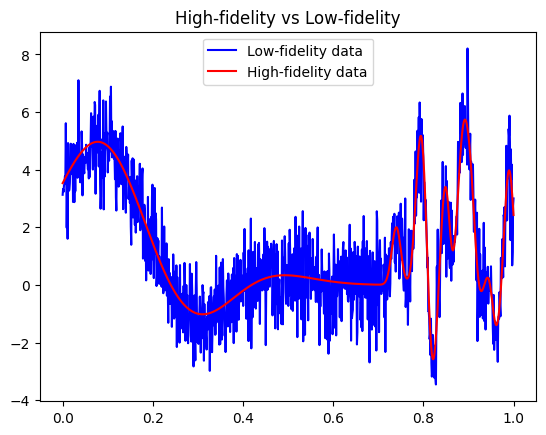

In [13]:
# Plot lf against hf data to see comparison
hf_points = domain[np.where(domain[:, 1] == 1)]
lf_points = domain[np.where(domain[:, 1] != 1)]

plt.plot(lf_points[:, 0], lf_points[:, -1], color = 'blue', label='Low-fidelity data' )
plt.plot(hf_points[:, 0], hf_points[:, -1], color = 'red', label='High-fidelity data')
plt.title('High-fidelity vs Low-fidelity')

plt.legend()

In [14]:
modelDict = {
    "TVR": (train_x_full_tvr, train_obj_tvr, cumulative_cost_tvr),
    "TVR_mod": (train_x_full_tvr_mod, train_obj_tvr_mod, cumulative_cost_tvr_mod),
    # "MF-MES": (train_x_full_mes, train_obj_mes, cumulative_cost_mes),
    # "SF-MES": (train_x_full_sfmes, train_obj_sfmes, cumulative_cost_sfmes),
    # "SF-EI" : (train_x_full_ei, train_obj_ei, cumulative_cost_ei),
    # "Random": (train_x_full_rand, train_obj_rand, cumulative_cost_rand), 
             }
dict_filename = save_dictionary(modelDict, batch=False)    

In [15]:
# Plot the fidelities.
import matplotlib.pyplot as plt

def plot_fidelities(samples, targets, title, total_domain, colours=['blue','red','green']):
    max_in_space= np.max(total_domain[np.where(total_domain[:, 1] == 1.0)])
    samples = samples.detach().numpy()
    targets = targets.detach().numpy()
    nb_iterations = len(samples) - 1
    fidelities = list(dict.fromkeys(samples[:, 1]))
    fidelities.sort()
    for fidelity in fidelities:
        fidelity_target=[]
        fidelity_iteration=[]
        for i in range(0, nb_iterations):
            if (samples[i,1] == fidelity):
                fidelity_target.append(targets[i])
                fidelity_iteration.append(i)
        # maximum_target.append(max(df_total[df_total['fidelity']==fidelity]['target']))
        legend_text = f'Fidelity: {fidelity}'
        plt.scatter(fidelity_iteration, fidelity_target, label=legend_text, color=colours[fidelities.index(fidelity)])
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for Best Fidelity')
    plt.legend(loc="lower right")
    plt.xlabel("Iteration Number")
    plt.ylabel("Target")
    plt.ylim([min(targets)-1, max(targets)+1])
    plt.title(title)

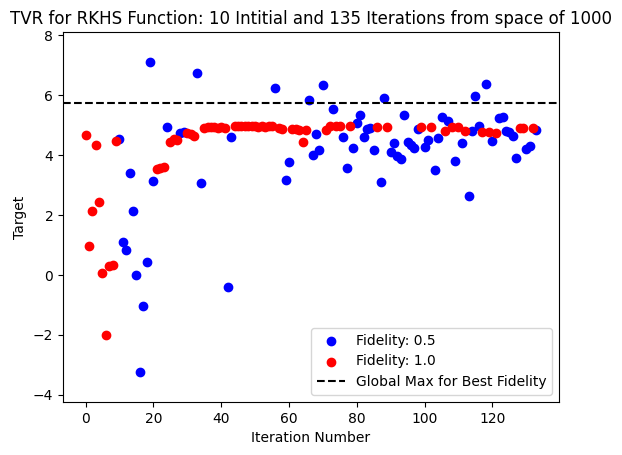

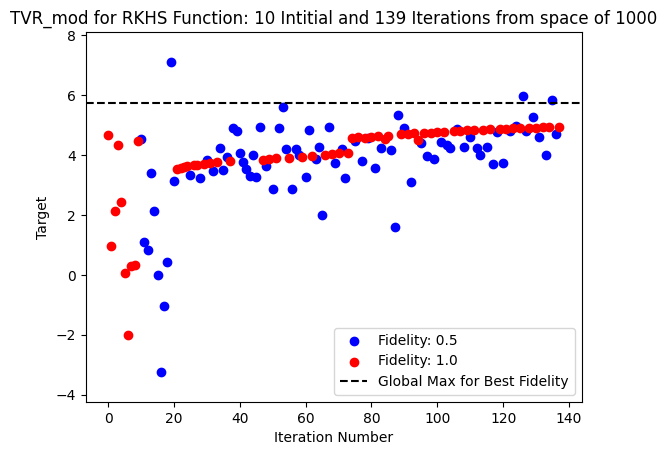

In [16]:
for key in modelDict:
    plot_fidelities(modelDict[key][0], modelDict[key][1], f'{key} for RKHS Function: {N_INIT} Intitial and {len(modelDict[key][0])} Iterations from space of {int(len(domain)/2)}', domain)
    plt.show()
# plot_fidelities(train_x_full_tvr, train_obj_tvr, f'TVR for RKHS Function: {N_INIT} Intitial and {len(train_x_full_tvr)} Iterations from space of {int(len(domain)/2)}', domain)
# plot_fidelities(train_x_full_ei, train_obj_ei, f'SF-EI for RKHS Function: {N_INIT} Intitial and {len(train_x_full_ei)} Iterations from space of {int(len(domain)/2)}', domain)
# plot_fidelities(train_x_full_sfmes, train_obj_sfmes, f'SFBO MES for RKHS Function: {N_INIT} Intitial and {len(train_x_full_sfmes)} Iterations from space of {int(len(domain)/2)}', domain)

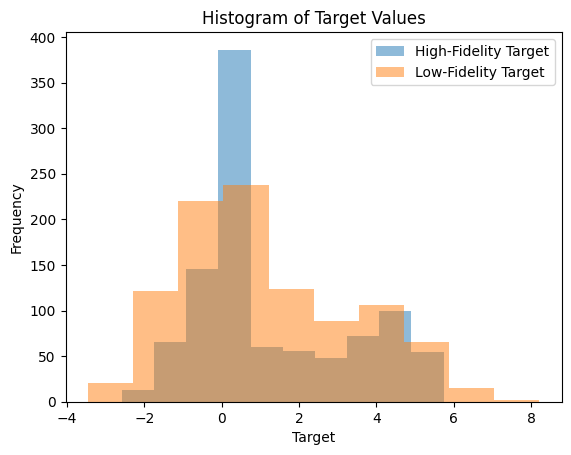

In [17]:
#Shows distribution of High-fidelity and Low-fidelity targets.
def plot_histogram(domain):
    high_fidelity = domain[np.where(domain[:, 1]==1.0)]
    low_fidelity = domain[np.where(domain[:, 1]==0.5)]
    plt.hist(high_fidelity[:, -1], label='High-Fidelity Target', bins=10, alpha=0.5)
    plt.hist(low_fidelity[:, -1], label='Low-Fidelity Target', bins=10, alpha=0.5)
    plt.title('Histogram of Target Values')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show() 

plot_histogram(domain)

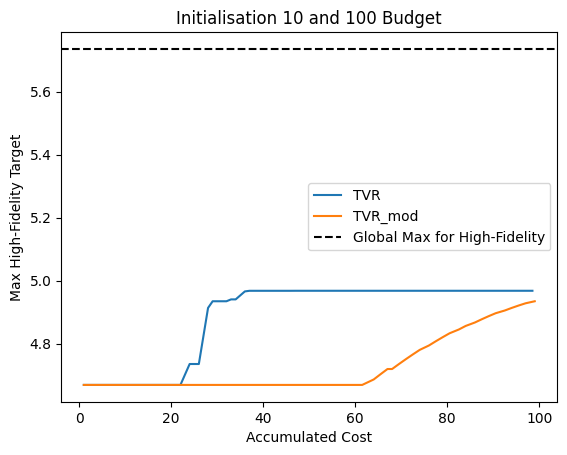

In [18]:
# Here we plot the maximum high-fidelity target reached so far with a given cost. 
def plot_cost(domain, dictionary, title): 
    max_in_space= np.max(domain[np.where(domain[:, 1] == 1.0)])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        cumulative_cost_array = np.array(cumulative_cost)
        hf_indices = np.where(train_x_full[:, 1]==1.0)
        high_fidelity_obj = train_obj[np.where(train_x_full[:, 1]==1.0)].detach().numpy()
        accum_target = []
        for i in range(len(high_fidelity_obj)):
            accum_target.append(max(high_fidelity_obj[0:i+1]))

        plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=search_alg)    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.title(title)
    plt.legend()

plot_cost(domain, modelDict,f'Initialisation {N_INIT} and {ALLOCATED_BUDGET} Budget' )

In [19]:
# Here we plot the HF points that were chosen by each fidelity.
def plot_target_per_iteration(domain, train_x_full, train_obj, iteration_no):
    hf_points = domain[np.where(domain[:, 1]==1.0)]
    hf_sorted_arg = hf_points[:, 0].argsort()
    hf_points = hf_points[hf_sorted_arg]
    plt.scatter(hf_points[:, 0], hf_points[:, -1], color='blue', label = 'Entire Domain')
    x_allfidelity_up_to_iter = train_x_full[0 : iteration_no + 1 ]
    y_allfidelity_up_to_iter = train_obj[0 : iteration_no + 1 ]
    plt.scatter(x_allfidelity_up_to_iter[np.where(x_allfidelity_up_to_iter[:, 1] == 1.)][:, 0], 
                y_allfidelity_up_to_iter[np.where(x_allfidelity_up_to_iter[:, 1] == 1.)][:, 0], 
                color='red',
                marker='x', 
                label='Evaluated Points' )
    plt.xlabel('x-value')
    plt.ylabel('Target')
    plt.title(f'Iteration {iteration_no}')
    plt.legend()

def plot_target_per_iteration_range(domain, train_x_full, train_obj, iteration_range, title, figsize):
    figure = plt.figure(figsize=figsize)
    no_of_rows = math.ceil(len(iteration_range) / 3) 
    for id, image_no in enumerate(range(len(iteration_range))):
        plt.subplot(no_of_rows, 3, id + 1)
        plot_target_per_iteration(domain, train_x_full, train_obj, iteration_range[image_no])
    plt.suptitle(title,  size=16)
    plt.subplots_adjust(top=0.95)


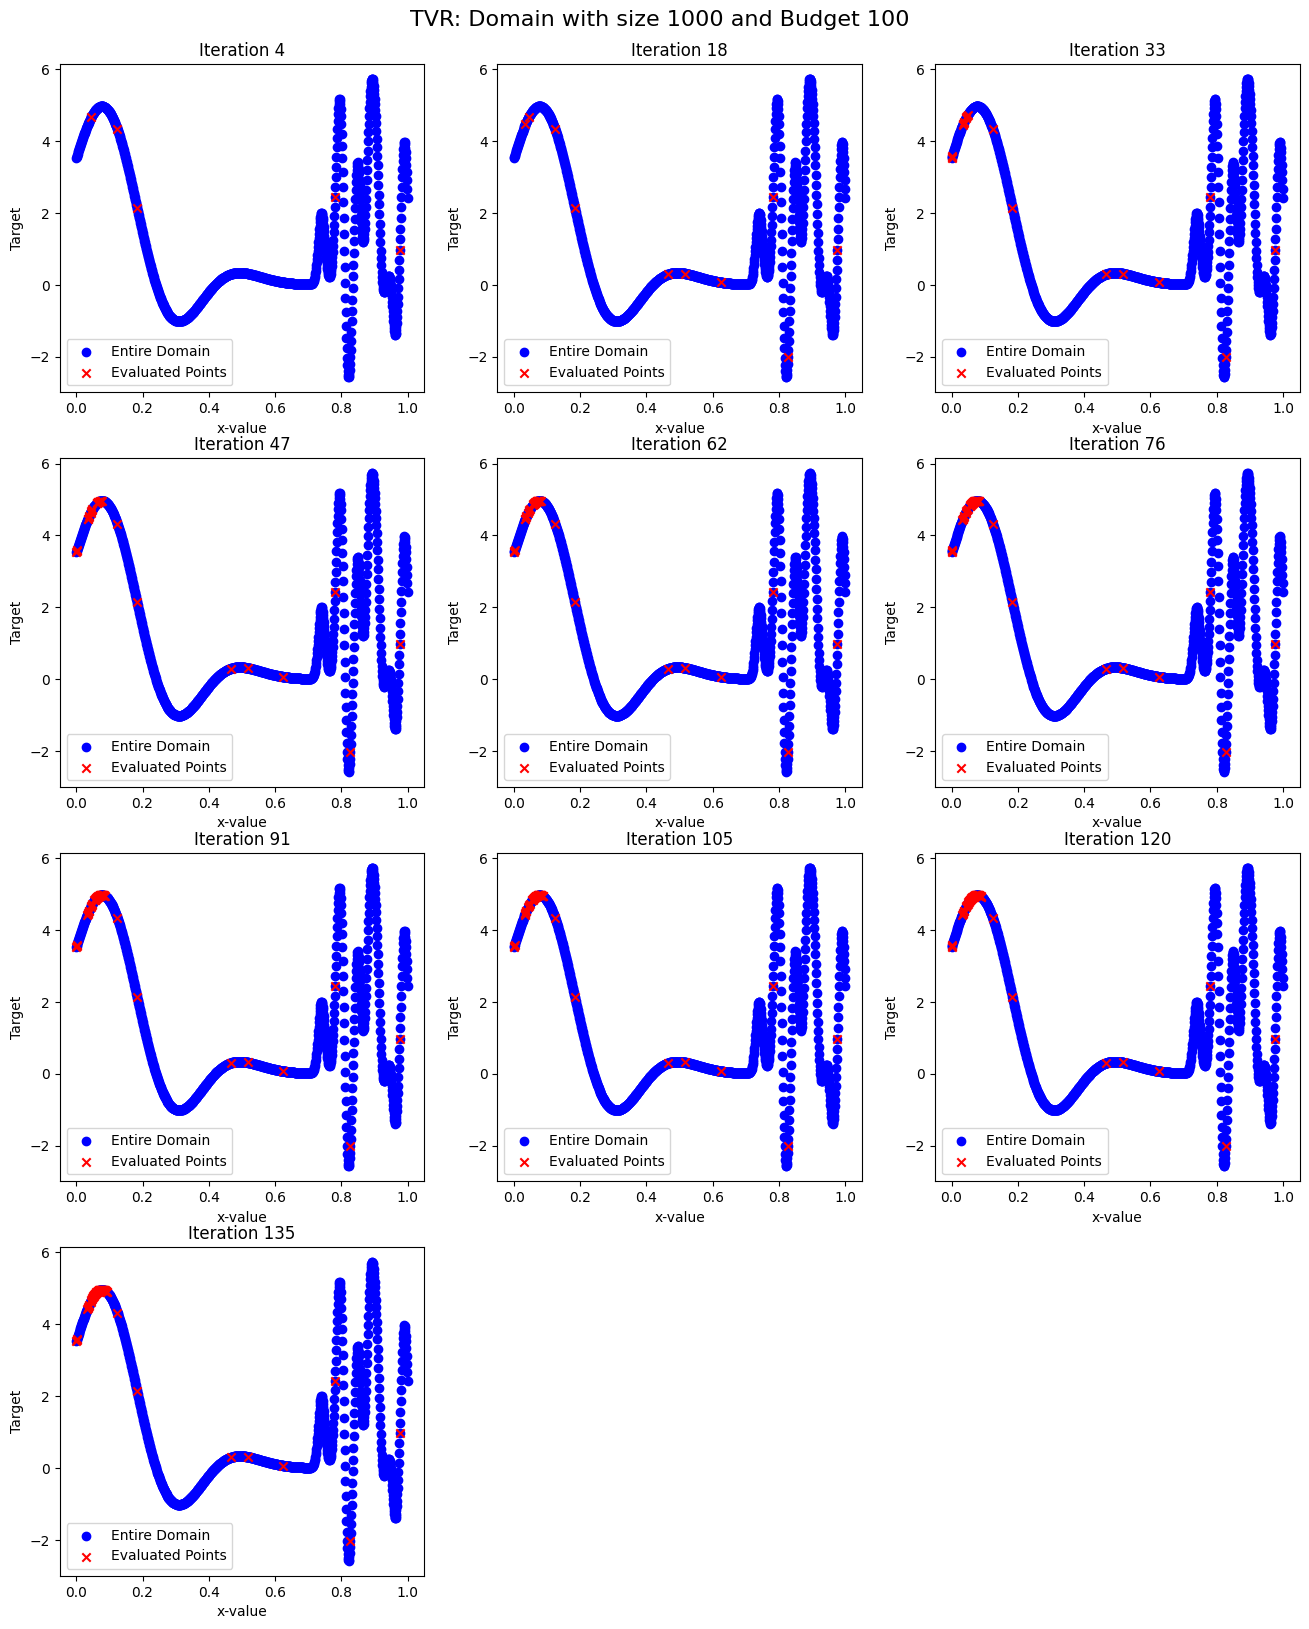

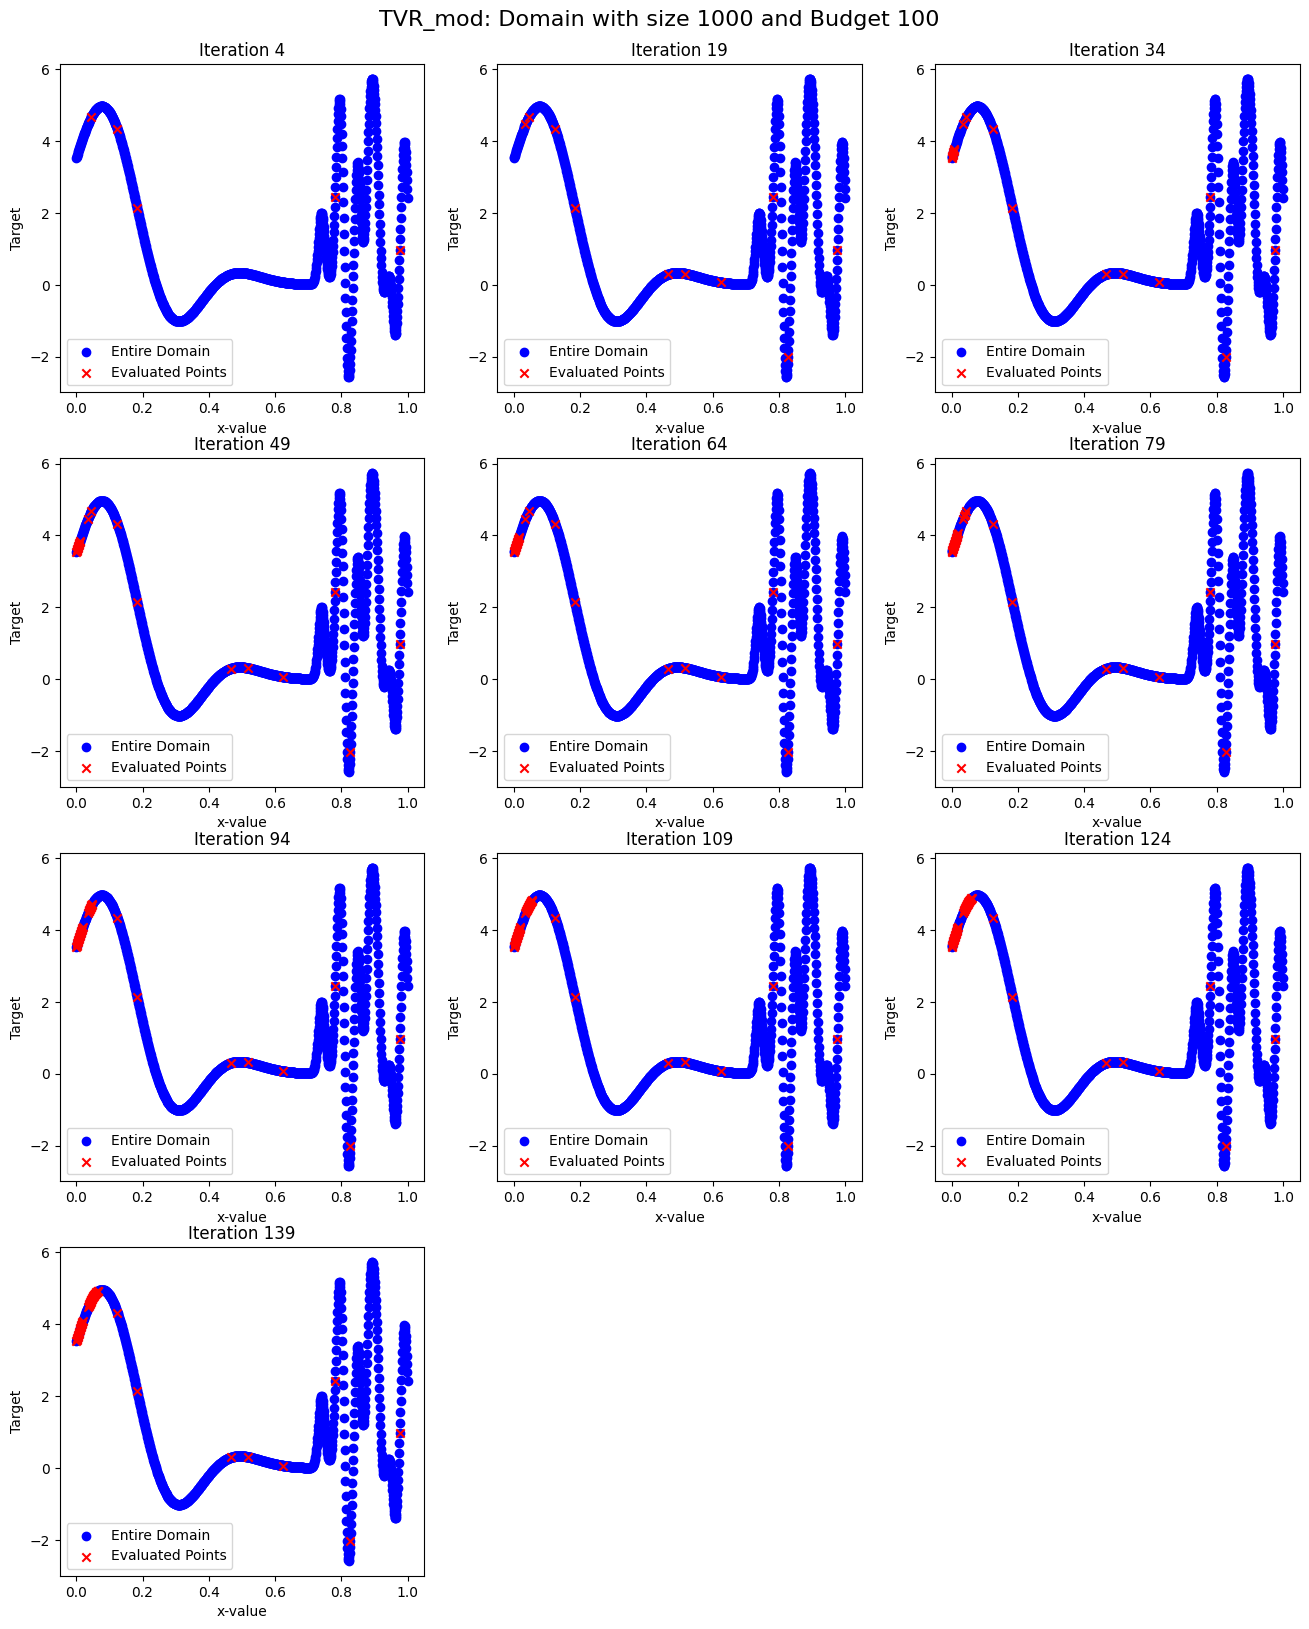

In [20]:
for key in modelDict:
    plot_target_per_iteration_range(
        domain, 
        modelDict[key][0], 
        modelDict[key][1], 
        # [5, 10, 20,  30,  40, 50, 60, 70, len(modelDict[key][0])],
        np.linspace(4, len(modelDict[key][0]), 10, dtype=int),
        f'{key}: Domain with size {int(len(domain)/2)} and Budget {ALLOCATED_BUDGET}',
        figsize=(16, 18)
        )

## ii) Batches and Average
Now we consider multiple runs and average the results.

In [9]:
# Adding in batch functionality
def run_entire_cycle_batch(experiments, 
                           domain_input, 
                           initial_sample_size, 
                           func, 
                           no_of_iterations=10000, 
                           allocated_budget=10000,
                           predefined_indices_batch=None, 
                           sf=False, 
                           file = True):
    train_x_full_batch = []
    train_obj_batch = []
    cumulative_cost_batch = [] 
    index_store_batch = []
    for j in range(experiments):
        predefined_indices = None if predefined_indices_batch is None else predefined_indices_batch[j]
        train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(domain_input, 
                                                                                        initial_sample_size,
                                                                                        predefined_indices=predefined_indices, 
                                                                                           sf=sf, 
                                                                                           file=file)
        train_x_full, train_obj, cumulative_cost, index_store = run_entire_cycle(
            train_x_full, 
            train_obj, 
            domain, 
            fidelity_history, 
            index_store, 
            func,
            sf=sf,
            no_of_iterations=no_of_iterations,
            allocated_budget=allocated_budget)       
  
        train_x_full_batch.append(train_x_full)
        train_obj_batch.append(train_obj)
        cumulative_cost_batch.append(cumulative_cost)
        index_store_batch.append(index_store)
    return train_x_full_batch, train_obj_batch, cumulative_cost_batch, index_store_batch

def run_entire_cycle_random_batch(no_of_iterations, experiments, fileName, predefined_indices_batch=None):
    # Here we will only consider high-fidelity points since we are just randomly choosing points and ignore the intitial sample
    # The predefined_indices_batch is a way to pass in predefined indices for the initial sample.
    # This can ensure fairness across the different algorithms. 
    train_x_full_batch = []
    train_obj_batch = []
    cumulative_cost_batch = []
    index_store_batch = []
    domain = np.loadtxt(fileName, delimiter=',')
    
    for i in range(experiments):
        x_train = None
        if predefined_indices_batch is not None:
            x_train, _, _, _, _ = convertMFDatatoSFData(domain, predefined_indices_batch[i])

        train_x_full, train_obj, cumulative_cost, index_store = run_entire_cycle_random(no_of_iterations, domain, x_train=x_train)
        train_x_full_batch.append(train_x_full)
        train_obj_batch.append(train_obj)
        cumulative_cost_batch.append(cumulative_cost)
        index_store_batch.append(index_store)
    return train_x_full_batch, train_obj_batch, cumulative_cost_batch, index_store_batch

In [63]:
# Debug to understand why repeated runs with same initial sample are slightly different. Float error?
# import warnings
# warnings.filterwarnings('ignore')
# N_ITER = 30
# N_EXP = 5
# fileName = 'SampleSpaces/20240606-114441.csv'
# train_x_full, train_obj, domain, index_store, budget = setUpInitialData(fileName, 10)

# train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, index_store_mes_batch, acquition_scores_batch = run_entire_cycle_batch_debug(
#     N_ITER,
#     N_EXP, 
#     train_x_full, 
#     train_obj, 
#     domain, 
#     budget,
#     index_store,
#     runMes
#     )

In [21]:
# N_ITER_BATCH = 30
N_EXP_BATCH = 5
INIT_SAMPLE_SIZE_BATCH=5
ALLOCATED_BUDGET_BATCH = 50
fileName = 'SampleSpaces/20240609-140133.csv'
domain = np.loadtxt(fileName, delimiter=',')

rand_sample = [random.sample(range(int(len(domain)/2)), INIT_SAMPLE_SIZE_BATCH) for j in range(N_EXP_BATCH)]
predefined_indices = [[2 * x  for x in  rand_sample[i]] + [1 + 2 * x for x in rand_sample[i]] for i in range(N_EXP_BATCH)]

train_x_full_tvr_batch, train_obj_tvr_batch, cumulative_cost_tvr_batch, index_store_tvr_batch = run_entire_cycle_batch(
    N_EXP_BATCH,
    fileName,
    INIT_SAMPLE_SIZE_BATCH, 
    runMes,
    allocated_budget = ALLOCATED_BUDGET_BATCH,
    predefined_indices_batch = predefined_indices
    );

train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, index_store_mes_batch = run_entire_cycle_batch(
    N_EXP_BATCH,
    fileName,
    INIT_SAMPLE_SIZE_BATCH, 
    runMes,
    allocated_budget = ALLOCATED_BUDGET_BATCH,
    predefined_indices_batch = predefined_indices
    );

train_x_full_sfmes_batch, train_obj_sfmes_batch, cumulative_cost_sfmes_batch, index_store_sfmes_batch = run_entire_cycle_batch(
    N_EXP_BATCH,
    fileName,
    INIT_SAMPLE_SIZE_BATCH, 
    runMes,
    allocated_budget = ALLOCATED_BUDGET_BATCH,
    sf=True,
    predefined_indices_batch = predefined_indices
    );

train_x_full_ei_batch, train_obj_ei_batch, cumulative_cost_ei_batch, index_store_ei_batch = run_entire_cycle_batch(
    N_EXP_BATCH,
    fileName,
    INIT_SAMPLE_SIZE_BATCH, 
    runEI,
    allocated_budget = ALLOCATED_BUDGET_BATCH,
    sf=True,
    predefined_indices_batch = predefined_indices
    );

train_x_full_random_batch, train_obj_random_batch, cumulative_cost_random_batch, index_store_random_batch = run_entire_cycle_random_batch(
    ALLOCATED_BUDGET_BATCH,
    N_EXP_BATCH,
    fileName,
    predefined_indices_batch=predefined_indices
    );


In [22]:
searchDictBatch = {
    "TVR": (train_x_full_tvr_batch, train_obj_tvr_batch, cumulative_cost_tvr_batch),
    "MF-MES": (train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch),
    "SF-MES": (train_x_full_sfmes_batch, train_obj_sfmes_batch, cumulative_cost_sfmes_batch),
    "SF-EI": (train_x_full_ei_batch, train_obj_ei_batch, cumulative_cost_ei_batch),
    "Random": (train_x_full_random_batch, train_obj_random_batch, cumulative_cost_random_batch)
                   }
batch_dict_filename = save_dictionary(searchDictBatch, batch=True)

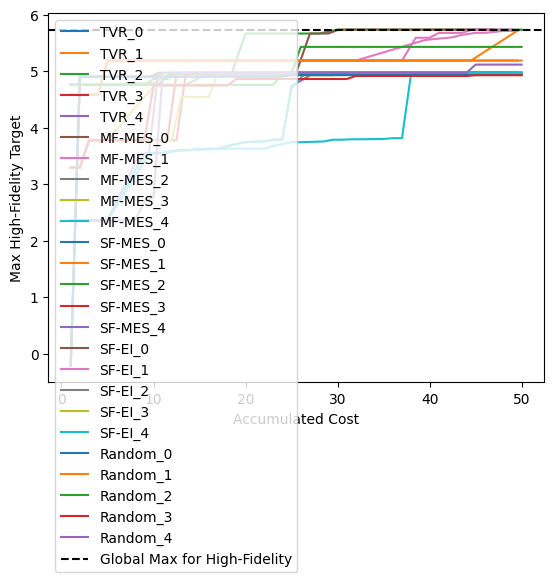

In [23]:
# This is code to debug the batch process a few cells later, showing the different runs individually, rather than averaged.
def plot_cost_batch_individual(domain, dictionary): 
    max_in_space= np.max(domain[np.where(domain[:, 1] == 1.0)])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        for j in range(len(train_x_full)):
            cumulative_cost_array = np.array(cumulative_cost[j])
            hf_indices = np.where(train_x_full[j][:, 1]==1.0)
            high_fidelity_obj = train_obj[j][np.where(train_x_full[j][:, 1]==1.0)].detach().numpy()
            accum_target = []
            for i in range(len(high_fidelity_obj)):
                accum_target.append(max(high_fidelity_obj[0:i+1]))

            plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=f"{search_alg}_{j}")    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.legend()
    
plot_cost_batch_individual(domain, searchDictBatch)

In [24]:
# Helper Function for Batch Case. This takes the cumulative cost array, extracts the high-fidelity targets, calculates the maximum up-to-that-stage
# and then spreads it out evenly over an  assigned range of regular intervals (of cumulative cost).
# i.e. the cost_range_input, so that we can compare different runs/experiments and compute an average.
# For example, if we have accumulated cost of [1, 1.5, 2, 2.5, 3.5] with targets [2.1, 0.9, 3.5, 2.3, 5].
# This should give an output over:
# [1,   1.5, 2,   2.5,   3,   3.5, 4, 4.5, 5  ] - see, evenly spaced (which with MF isn't guaranteed)
# [2.1, 2.1, 3.5, 3.5,   3.5, 5,   5,   5,  5 ] - we only take the maximum hf target.

def discretise_cost_and_maximise(high_fidleity_points, cost_range_input, cumulative_cost_array_input, hf_indices_input):
    accum_target = []
    # This part generates the accumulated maximum of just each high-fidleity point so far.
    for i in range(len(high_fidleity_points)):
        accum_target.append(max(high_fidleity_points[0:i+1]))

    accum_target = np.array(accum_target)
    max_target = []
    for id, x in enumerate(cost_range_input):
        if x in cumulative_cost_array_input[ hf_indices_input ]:
            max_target.append(accum_target[np.where(cumulative_cost_array_input[ hf_indices_input ] == x )[0]][0].item())
        elif id == 0:
            max_target.append(0)
        else:
            max_target.append(max_target[id-1])
    return max_target
#Unit-test:
print(discretise_cost_and_maximise( [2.1, 0.9, 3.5, 2.3, 5], [1,   1.5, 2,   2.5,   3,   3.5, 4, 4.5, 5  ] , np.array([1, 1.5, 2, 2.5, 3.5]), [0,1,2,3,4]))

[2.1, 2.1, 3.5, 3.5, 3.5, 5.0, 5.0, 5.0, 5.0]


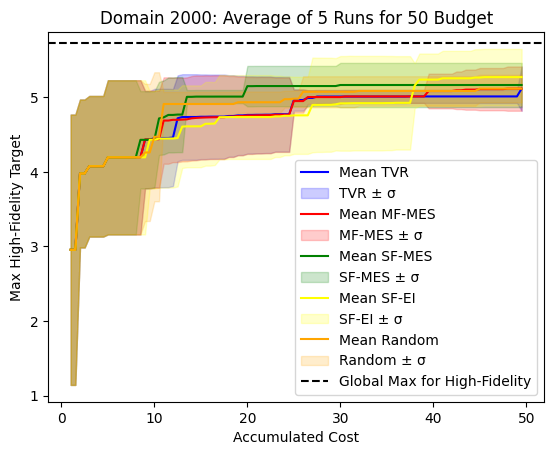

In [27]:
# Here we plot the mean maximum high-fidelity target reached so far with SD for a batch of experiments. 
def plot_cost_batch(domain, dictionary, title, allocated_budget, colour=['blue', 'red', 'green', 'yellow', 'orange']): 
    max_in_space= np.max(domain[np.where(domain[:, 1] == 1.0)])
    for id, search_alg in enumerate(dictionary):
        aggregate_max_target = []
        train_x_full_batch, train_obj_batch, cumulative_cost_batch = dictionary[search_alg]
        cost_range = list(np.arange(1,allocated_budget,0.5))
        
        for batch_no in range(len(train_x_full_batch)):
            cumulative_cost_array = np.array(cumulative_cost_batch[batch_no])
            hf_indices = np.where(train_x_full_batch[batch_no][:, 1]==1.0)
            high_fidelity_obj = train_obj_batch[batch_no][np.where(train_x_full_batch[batch_no][:, 1]==1.0)].detach().numpy().squeeze(-1)
            max_target = discretise_cost_and_maximise(high_fidelity_obj, cost_range, cumulative_cost_array, hf_indices)
            aggregate_max_target.append(max_target)
        
        maximum_aggregate_mean = np.mean(aggregate_max_target, axis = 0)
        maximum_aggregate_lowerbound = maximum_aggregate_mean - np.std(aggregate_max_target, axis = 0)
        maximum_aggregate_upperbound = maximum_aggregate_mean + np.std(aggregate_max_target, axis = 0)
        plt.plot(cost_range, maximum_aggregate_mean, label=f'Mean {search_alg}', color=colour[id])
        plt.fill_between(x=cost_range, y1=maximum_aggregate_lowerbound, y2=maximum_aggregate_upperbound, color=colour[id], alpha=0.2, label=f'{search_alg} \xb1 \u03C3')    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.title(title)
    plt.legend(loc='lower right')

plot_cost_batch(domain, searchDictBatch, f'Domain {int(len(domain)/2)}: Average of {N_EXP_BATCH} Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH )

## Instantaneous and Cumulative Regret

In [24]:
# Instantaneous Regret and Cumulative Regret
# We focus only on the high-fidelity points.

def discretise_evenly_for_averaging(stepwise_objective_points, cost_range_input, cumulative_cost_array_input):
    obj_target = []
    for id, x in enumerate(cost_range_input):
        if x in cumulative_cost_array_input:
            obj_target.append(stepwise_objective_points[np.where(cumulative_cost_array_input == x )[0]][0].item())
        elif id == 0:
            obj_target.append(0)
        else:
            obj_target.append(obj_target[id-1])
    return obj_target

def create_cumulative_regret(domain, train_x_batch, train_obj_batch, cumulative_cost_batch, cost_range, cum=True):
    max_in_space = np.max(domain[np.where(domain[:, 1] == 1.0)])
    aggregate_regret = []
    for batch_no in range(len(train_x_batch)):
            cumulative_cost_array = np.array(cumulative_cost_batch[batch_no])
            obj_modified = []
            for i in range(len(train_obj_batch[batch_no])):
                if train_x_batch[batch_no][i, 1]==1.0:  
                    obj_modified.append(train_obj_batch[batch_no][i].item())
                else:
                    # If low-fidelity point, just take last high-fidelity point.
                    candidate = 0 if i ==0 else obj_modified[-1]
                    obj_modified.append(candidate)
            obj_modified = np.array(obj_modified)
            even_obj_over_range = discretise_evenly_for_averaging(obj_modified, cost_range, cumulative_cost_array)
            instantaneous_regret = max_in_space - even_obj_over_range
            cumulative_regret = [sum(instantaneous_regret[: i + 1]) for i in range(len(instantaneous_regret))]
            regret = cumulative_regret if cum else instantaneous_regret
            aggregate_regret.append(regret)
            
    aggregate_regret_mean = np.mean(aggregate_regret, axis = 0)
    aggregate_regret_lowerbound = aggregate_regret_mean - np.std(aggregate_regret, axis = 0)
    aggregate_regret_upperbound = aggregate_regret_mean + np.std(aggregate_regret, axis = 0)
    return aggregate_regret_mean, aggregate_regret_lowerbound, aggregate_regret_upperbound
            
def plot_instantaneous_and_cumulative_regret_batch(domain, dictionary, title, allocated_budget, cum=True, colour=['blue', 'red', 'green', 'yellow']):
    # plt.figure(figsize=(16, 15))
    for id, search_alg in enumerate(dictionary):
        train_x_full_batch, train_obj_batch, cumulative_cost_batch = dictionary[search_alg]
        cost_range = list(np.arange(1,allocated_budget,0.5))
        aggregate_regret_mean, aggregate_regret_lowerbound, aggregate_regret_upperbound = create_cumulative_regret(domain, 
                                                                                                                   train_x_full_batch, 
                                                                                                                   train_obj_batch, 
                                                                                                                   cumulative_cost_batch, 
                                                                                                                   cost_range, 
                                                                                                                   cum)

        plt.plot(cost_range, aggregate_regret_mean, label=f'Mean {search_alg}', color=colour[id])
        plt.fill_between(x=cost_range, y1=aggregate_regret_lowerbound, y2=aggregate_regret_upperbound, color=colour[id], alpha=0.2, label=f'{search_alg} \xb1 \u03C3')    

    plt.xlabel('Accumulated Cost')
    plt.ylabel(f'{"Cumulative" if cum else "Instantaneous"} Regret')
    plt.title(title)
    plt.legend(loc='lower right')


In [20]:
plot_instantaneous_and_cumulative_regret_batch(domain, searchDictBatch, f'Domain {int(len(domain)/2)}: Average of {N_EXP_BATCH} Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH, cum=False )

NameError: name 'plot_instantaneous_and_cumulative_regret_batch' is not defined

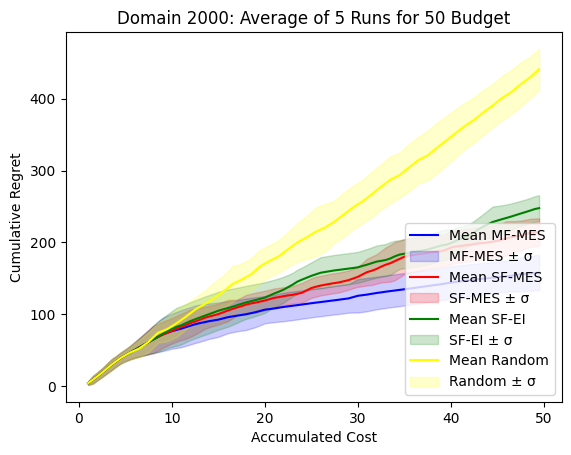

In [34]:
plot_instantaneous_and_cumulative_regret_batch(domain, searchDictBatch, f'Domain {int(len(domain)/2)}: Average of {N_EXP_BATCH} Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH, cum=True )

## Investigate Effect of Correlation Between High and Low Fidelities

In [3]:
def create_correlation_dict(no_points, corr_parameters):
    range_100 = np.linspace(0, 1, no_points)
    high_fid = np.array([ rkhs_synth(x) for x in range_100])
    corr_dict = {'base': range_100, '1': high_fid}
    gaussian_noise = np.array([random.gauss(0, 50) for x in range(0, no_points) ])
    for n in corr_parameters:
        low_fid = np.add(high_fid, 1/n * gaussian_noise)
        correlation = np.corrcoef(high_fid, low_fid)[0,1]
        corr_dict[str(correlation)] = low_fid
    return corr_dict

In [4]:
# output = create_correlation_dict(100, [1,2,3,4,5,6,7,8,9,10,20,30,40,50])
# output = create_correlation_dict(200, [3,6,9,15, 20, 25, 30, 50])
output = create_correlation_dict(200, [3, 10, 20, 30, 50])

print(output.keys())
fileName = save_dictionary(output, root='CorrelationDictionaries')
print(fileName)
corr_dictionary = load_dictionary(fileName)

dict_keys(['base', '1', '0.0004996813788826055', '0.2693651262276226', '0.5614983869770175', '0.7329527210029416', '0.8823689715722955'])
CorrelationDictionaries/20240621-152914


In [18]:
def regret_correlation(correlation_dictionary, no_of_expts, init_sample_size, allocated_budget):
    
    rand_sample = [random.sample(range(int(len(correlation_dictionary['base'])/2)), init_sample_size) for j in range(no_of_expts)]
    predefined_indices = [[2 * x  for x in  rand_sample[i]] + [1 + 2 * x for x in rand_sample[i]] for i in range(no_of_expts)]

    regret_array_final= []
    regret_dictionary = {'Correlation': correlation_dictionary}
    correlations = []
    keys = np.array([x for x in correlation_dictionary.keys()])
    base = correlation_dictionary['base']
    hf_points = correlation_dictionary['1']
    cost_range = list(np.arange(1,allocated_budget,0.5))

    for i in keys[1:]:
        correlations.append(float(i))
        domain = []
        lf_points = correlation_dictionary[i]

        for j in range(len(correlation_dictionary[i])):
            domain.append([base[j], 1.0, hf_points[j]])
            domain.append([base[j], 0.5, lf_points[j]])
        domain = np.array(domain)

        train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, index_store_mes_batch \
            = run_entire_cycle_batch(domain_input= domain,
                                    experiments =no_of_expts , 
                                    initial_sample_size= init_sample_size, 
                                    func=runMes, 
                                    allocated_budget=allocated_budget,
                                    predefined_indices_batch = predefined_indices,
                                    file=False)
        
        regret_mean, _, _ = create_cumulative_regret(domain, 
                                                     train_x_full_mes_batch, 
                                                     train_obj_mes_batch, 
                                                     cumulative_cost_mes_batch, 
                                                     cost_range, 
                                                     cum=True)
        regret_dictionary[i]=(train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, domain)
        regret_array_final.append(regret_mean[-1])
    fileName = save_dictionary(regret_dictionary, root='CorrelationRegret')
    return regret_array_final, correlations, fileName, regret_dictionary

def plot_corr_regret(regret_array, correlations):   
    plt.scatter(correlations, regret_array)
    plt.xlabel('Correlation')
    plt.ylabel('Cumulative Regret')
    plt.title(f'Fidelity Correlation vs Cumlative Regret at {ALLOCATED_BUDGET_BATCH} Budget')

CorrelationRegret/20240619-113431


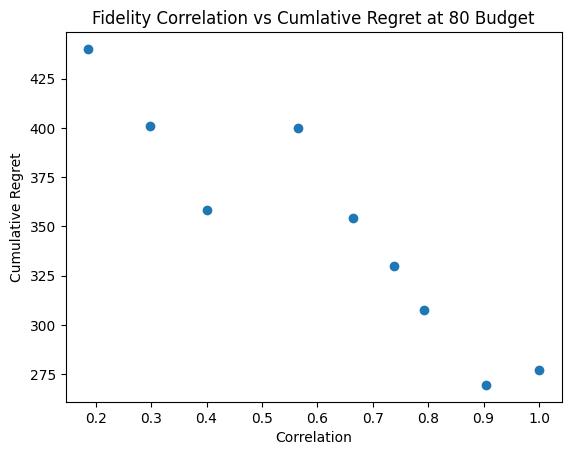

In [25]:
N_EXP_BATCH = 5
INIT_SAMPLE_SIZE_BATCH = 5
ALLOCATED_BUDGET_BATCH = 80

regret_array_output, correlations, fileName, regret_dictionary = regret_correlation(corr_dictionary, N_EXP_BATCH, INIT_SAMPLE_SIZE_BATCH, ALLOCATED_BUDGET_BATCH )
print(fileName)
plot_corr_regret(regret_array_output, correlations)

In [27]:
# corr_dict = load_dictionary('CorrelationRegret/20240615-152922')
# corr_dict = load_dictionary('CorrelationRegret/20240616-101116')
# corr_dict = load_dictionary('CorrelationRegret/20240618-125500')
corr_dict = regret_dictionary

In [29]:
corr_dict.keys()

dict_keys(['Correlation', '1', '0.1862616509573919', '0.29890312068950375', '0.4003310518262977', '0.5646513103802002', '0.6649210198555442', '0.738809819622798', '0.7931600482742485', '0.9049465672216095'])

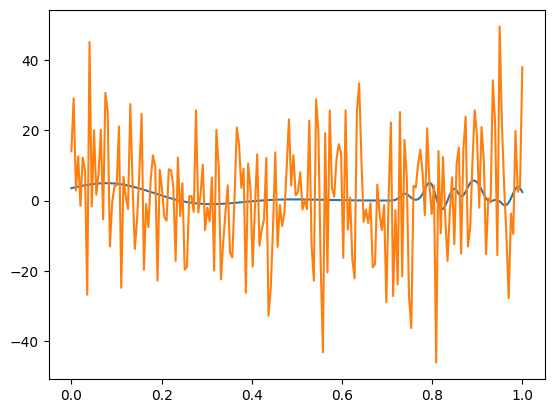

: 

In [54]:
train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, domain = corr_dict['0.1862616509573919']
# for i in range(len(train_x_full_mes_batch)):
#     plot_target_per_iteration_range(
#         domain, 
#         train_x_full_mes_batch[i], 
#         train_obj_mes_batch[i], 
#         [5, 10, 20,  30,  40, 50, 60, 70, len(train_x_full_mes_batch[i])],
#         f'0.1862616509573919: Domain with size {int(len(domain)/2)} and Budget {ALLOCATED_BUDGET}',
#         figsize=(16, 15)
#         )
plt.plot(domain[np.where(domain[:, 1] ==1)][:, 0], domain[np.where(domain[:, 1] ==1)][:, 2])
plt.plot(domain[np.where(domain[:, 1] !=1)][:, 0], domain[np.where(domain[:, 1] !=1)][:, 2])


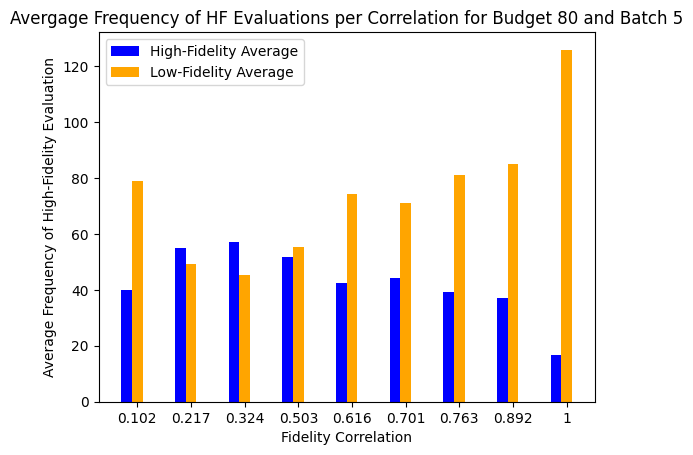

In [39]:

def plot_corr_hf_frequency(corr_dictionary):
    x_axis = []
    y_axis_hf = []
    y_axis_lf = []
    corre_keys = [key for key in corr_dictionary.keys() if (key != 'Correlation' and key != '1' )]
    # We want the highest fidelity toa pepar at the nd for visual reasons.
    corre_keys.append('1') 
    for key in corre_keys:
        x_axis.append(key[:5]) 
        train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch = corr_dict[key]
        batch_size = len(train_x_full_mes_batch)
        high_fidelity_count_batch = []
        low_fidelity_count_batch = []
        for experiment in train_x_full_mes_batch:
            hf_count = sum(experiment[:, 1] == 1.0).item()
            lf_count = sum(experiment[:, 1] != 1.0).item()
            high_fidelity_count_batch.append(hf_count)
            low_fidelity_count_batch.append(lf_count)
        y_axis_hf.append(np.mean(high_fidelity_count_batch))
        y_axis_lf.append(np.mean(low_fidelity_count_batch))

    X_axis = np.arange(len(x_axis)) 
    plt.bar(X_axis -0.2, y_axis_hf, 0.2, label='High-Fidelity Average', color='blue')
    plt.bar(X_axis, y_axis_lf, 0.2, label='Low-Fidelity Average', color='orange')
    plt.xlabel('Fidelity Correlation')
    plt.ylabel('Average Frequency of High-Fidelity Evaluation')
    plt.title(f'Avergage Frequency of HF Evaluations per Correlation for Budget {ALLOCATED_BUDGET_BATCH} and Batch {N_EXP_BATCH}')
    plt.legend()
    plt.xticks(X_axis, x_axis) 

plot_corr_hf_frequency(corr_dict)

## Investigate correlation on Variance and Mean (Kernel investigation)
Here we fit a Gaussian regressor on 10 HF points and 20 LF points then evaluate the posterior at fixed points to see how the vrainace and mean change depending on correlations.

In [60]:
output = create_correlation_dict(200, [3, 10, 20, 30, 50])

print(output.keys())
fileName = save_dictionary(output, root='CorrelationDictionaries')
print(fileName)
corr_dictionary = load_dictionary(fileName)

dict_keys(['base', '1', '0.1622458994773245', '0.3896931870635698', '0.6212226629118129', '0.7580620518006465', '0.8850744899299932'])
CorrelationDictionaries/20240621-170623


In [61]:
from botorch.models.transforms.outcome import Standardize
from botorch import fit_gpytorch_mll

def create_kernel_dictionary(corr_dictionary, eval_points_size=5, lf_train_points_size = 20, all_evaluation=False):
    evaluation_points_indices = []
    space_size_int = len(corr_dictionary['base'])
    space_size = range(space_size_int)
    if all_evaluation:
        evaluation_points_indices = list(space_size)
    else:
        evaluation_points_indices = random.sample(space_size, eval_points_size)
        evaluation_points_indices.sort()

    lf_train_points_indices = random.sample(space_size, lf_train_points_size)
    hf_train_points_indices = lf_train_points_indices[0:lf_train_points_size//2]
    kernel_dictionary = {}
    evaluation_points = []
    corr_dict_keys = [x for x in corr_dictionary.keys() if x != 'base' and x != '1']
    corr_dict_keys.append('1')

    for i in evaluation_points_indices:
        evaluation_points.append([corr_dictionary['base'][i], 1])
    for key in corr_dict_keys:
        train_points = []
        for i in lf_train_points_indices:
            train_points.append([corr_dictionary['base'][i], 0.5, corr_dictionary[key][i]])
        for i in hf_train_points_indices:
            train_points.append([corr_dictionary['base'][i], 1, corr_dictionary['1'][i]])

        train_points = np.array(train_points)
        model = SingleTaskMultiFidelityGP(torch.tensor(train_points[:, :-1]), torch.tensor(train_points[:, -1]).reshape(-1, 1), data_fidelity=1)

        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        posterior = model.posterior(torch.tensor(np.array(evaluation_points)))
        mean = posterior.mean.detach()
        var = posterior.variance
        kernel_dictionary[key] = [mean, var]
    fileName = save_dictionary(kernel_dictionary, root='kernel_dictionary')
    return kernel_dictionary, evaluation_points_indices, lf_train_points_indices, hf_train_points_indices, corr_dict_keys, fileName


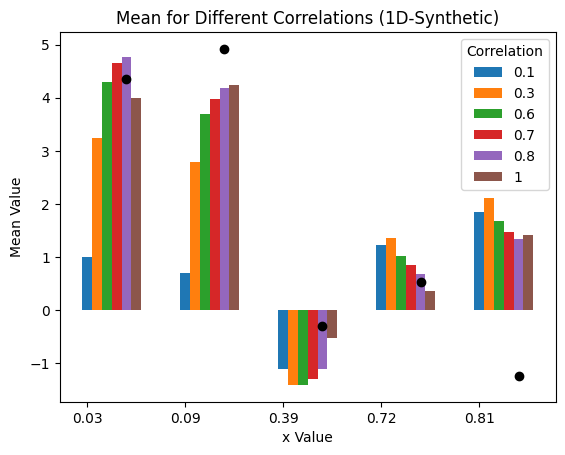

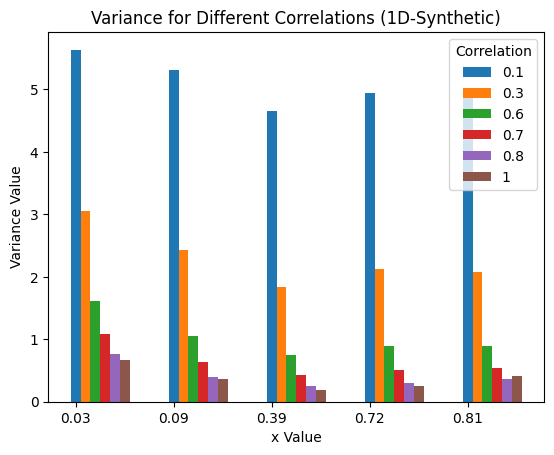

In [55]:
kernel_dictionary, evaluation_points_indices, lf_train_points_indices, hf_train_points_indices, corr_dict_keys, fileName \
= create_kernel_dictionary(corr_dictionary)
X_axis = np.arange(len(evaluation_points_indices)) 

for index, key in enumerate(corr_dict_keys):
    plt.bar(X_axis + index * 0.1, kernel_dictionary[key][0].detach().flatten(), label= corr_dict_keys[index][:3], width=0.1 )
plt.scatter(X_axis + 2*0.2, corr_dictionary['1'][evaluation_points_indices], color='black')
plt.xlabel('x Value')
plt.ylabel('Mean Value')
plt.legend(title='Correlation')
plt.title('Mean for Different Correlations (1D-Synthetic)')
plt.xticks(X_axis, [str(x)[:4] for x in corr_dictionary['base'][evaluation_points_indices]])
plt.show()

for index, key in enumerate(corr_dict_keys):
    plt.bar(X_axis + index * 0.1, kernel_dictionary[key][1].detach().flatten(), label= corr_dict_keys[index][:3], width=0.1 )
plt.xlabel('x Value')
plt.ylabel('Variance Value')
plt.legend(title='Correlation')
plt.title('Variance for Different Correlations (1D-Synthetic)')
plt.xticks(X_axis, [str(x)[:4] for x in corr_dictionary['base'][evaluation_points_indices]])
plt.show()

IndexError: invalid index to scalar variable.

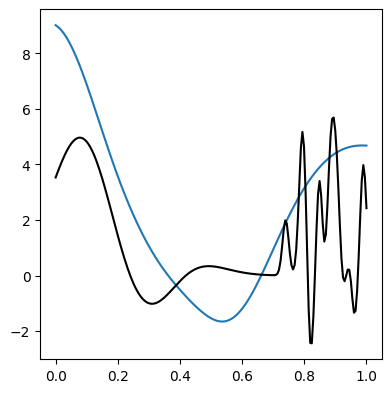

In [63]:
kernel_dictionary, evaluation_points_indices, lf_train_points_indices, hf_train_points_indices, corr_dict_keys, fileName \
= create_kernel_dictionary(corr_dictionary, all_evaluation=True)
figure = plt.figure(figsize=(15,10))
no_of_rows = math.ceil(len(kernel_dictionary.keys()) / 3) 
for index, key in enumerate(corr_dict_keys):
    plt.subplot(no_of_rows, 3, index + 1)
    plt.plot(corr_dictionary['base'][evaluation_points_indices], kernel_dictionary[key][0].detach().flatten(), label= corr_dict_keys[index][:3])
    plt.plot(corr_dictionary['base'], corr_dictionary['1'], color='black', label='True Function')
    plt.scatter(corr_dictionary['base'][hf_train_points_indices], corr_dictionary['1'][0][hf_train_points_indices].detach().flatten(), label = 'HF Training Points')
    plt.scatter(corr_dictionary['base'][lf_train_points_indices], corr_dictionary[key][0][lf_train_points_indices].detach().flatten(), label = 'LF Training Points')
    plt.xlabel('x Value')
    plt.ylabel('Mean Value')
    plt.legend(title='Correlation')
plt.suptitle('Mean for Different Correlations (1D-Synthetic)', size=16)
plt.subplots_adjust(top=0.95)

## How does cost/fidelity affect the frequency of HF Evaluations?


In [25]:
# Create domains with different fidelities:
def create_fidelity_dict(no_points, fidelity_list, sd=1):
    Xpr = np.linspace(0, 1, no_points)
    rand_noise_array = np.array([random.gauss(0, sd) for x in range(0, no_points)])
    fid_dict = {}
    for low_fidelity in fidelity_list:
        domain = []
        for i in range(len(Xpr)):
            rkhs_exact = rkhs_synth(Xpr[i])
            domain.append( [Xpr[i], 1.0, rkhs_exact])
            domain.append( [Xpr[i], low_fidelity, rkhs_synth(Xpr[i]) + rand_noise_array[i]])
        fid_dict[str(low_fidelity)] = np.array(domain)
    return fid_dict

In [26]:
# Function is very similar to regret_correlation above, but there are differences. Could refactor into one later.
def regret_fidelity(fidelity_dictionary, no_of_expts, init_sample_size, allocated_budget, cost_interval = 0.5): 
    
    keys = list(fidelity_dictionary.keys())
    rand_sample = [random.sample(range(int(len(fidelity_dictionary[keys[0]])/2)), init_sample_size) for j in range(no_of_expts)]
    predefined_indices = [[2 * x  for x in  rand_sample[i]] + [1 + 2 * x for x in rand_sample[i]] for i in range(no_of_expts)]

    fidelities = []
    regret_array_final= []
    regret_dictionary = {'Fidelity': fidelity_dictionary}
    cost_range = list(np.arange(1, allocated_budget, cost_interval))

    for key in keys:
        domain = fidelity_dictionary[key]
        fidelities.append(float(key))
        train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, index_store_mes_batch \
            = run_entire_cycle_batch(domain_input = domain,
                                    experiments =no_of_expts , 
                                    initial_sample_size= init_sample_size, 
                                    func=runMes, 
                                    allocated_budget=allocated_budget,
                                    predefined_indices_batch = predefined_indices,
                                    file=False)
        
        regret_mean, _, _ = create_cumulative_regret(domain, 
                                                     train_x_full_mes_batch, 
                                                     train_obj_mes_batch, 
                                                     cumulative_cost_mes_batch, 
                                                     cost_range, 
                                                     cum=True)
        regret_dictionary[key]=(train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch)
        regret_array_final.append(regret_mean[-1])
    fileName = save_dictionary(regret_dictionary, root='FidelityRegret')
    return regret_array_final, fidelities, fileName, regret_dictionary

def plot_fid_regret(regret_array, fidelities):   
    plt.scatter(fidelities, regret_array)
    plt.xlabel('Fidelity')
    plt.ylabel('Averaged Cumulative Regret')
    plt.title(f'Fidelity vs Cumlative Regret at {ALLOCATED_BUDGET_BATCH} Budget')

In [27]:
fid_dict = create_fidelity_dict(200, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
save_dictionary(fid_dict, root='FidelityDictionaries')

'FidelityDictionaries/20240618-114640'

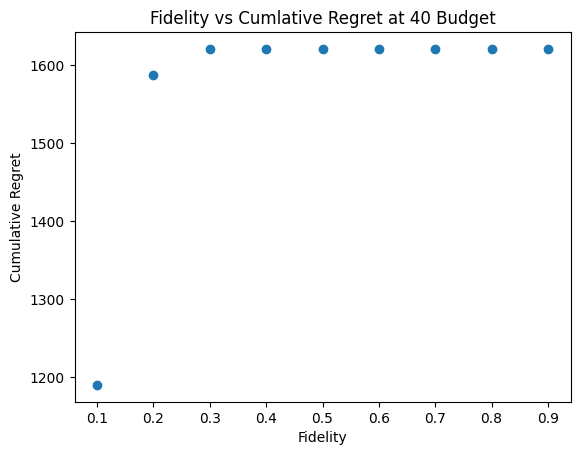

In [28]:
N_EXP_BATCH = 10
INIT_SAMPLE_SIZE_BATCH = 5
ALLOCATED_BUDGET_BATCH = 40
regret_array_final, fidelities, fileName, regret_dictionary = regret_fidelity(fid_dict, N_EXP_BATCH, INIT_SAMPLE_SIZE_BATCH, ALLOCATED_BUDGET_BATCH, cost_interval = 0.1)
plot_fid_regret(regret_array_final, fidelities)

In [29]:
# regret_dictionary = load_dictionary('FidelityRegret/20240616-214724')
print(fileName)

FidelityRegret/20240618-121343


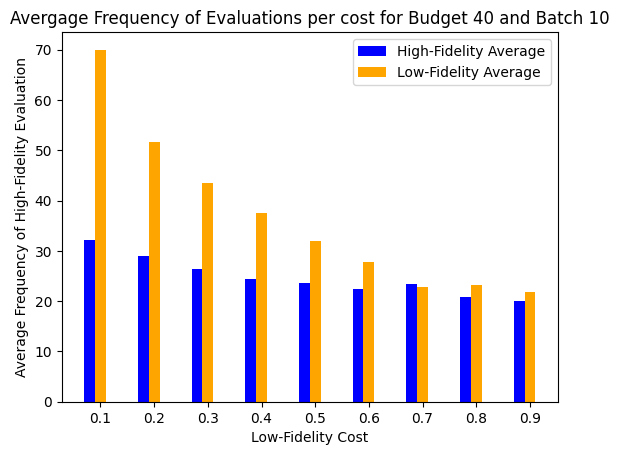

In [31]:
def plot_fid_hf_frequency(fid_dictionary):
    x_axis = []
    y_axis_hf = []
    y_axis_lf = []
    fid_keys = [key for key in fid_dictionary.keys() if (key != 'Fidelity' )]
    # We want the highest fidelity toa pepar at the nd for visual reasons.
    for key in fid_keys:
        x_axis.append(float(key[:5])) 
        train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch = fid_dictionary[key]
        batch_size = len(train_x_full_mes_batch)
        high_fidelity_count_batch = []
        low_fidelity_count_batch = []
        for experiment in train_x_full_mes_batch:
            hf_count = sum(experiment[:, 1] == 1.0).item()
            lf_count = sum(experiment[:, 1] != 1.0).item()
            high_fidelity_count_batch.append(hf_count)
            low_fidelity_count_batch.append(lf_count)
        y_axis_hf.append(np.mean(high_fidelity_count_batch))
        y_axis_lf.append(np.mean(low_fidelity_count_batch))

    X_axis = np.arange(len(x_axis)) 
    plt.bar(X_axis -0.2, y_axis_hf, 0.2, label='High-Fidelity Average', color='blue')
    plt.bar(X_axis, y_axis_lf, 0.2, label='Low-Fidelity Average', color='orange')
    plt.xlabel('Low-Fidelity Cost')
    plt.ylabel('Average Frequency of High-Fidelity Evaluation')
    plt.legend()
    plt.xticks(X_axis, x_axis) 
    plt.title(f'Avergage Frequency of Evaluations per cost for Budget {ALLOCATED_BUDGET_BATCH} and Batch {N_EXP_BATCH}')

# regret_dictionary = load_dictionary(fileName)
plot_fid_hf_frequency(regret_dictionary)
